# Session 2: Objective Functions and Supervised Learning

### Neil D. Lawrence


In [1]:
import pods
import numpy as np
import matplotlib.pyplot as plt
import mlai
import teaching_plots as plot

%matplotlib inline

### Objective Function

- Last week we motivated the importance of probability.
- This week we motivate the idea of the 'objective function'.

### Classification

- In classification we take in a *feature matrix* and make predictions of *class labels* given the features. 
- Our features are $\mathbf{x}_i$ for the $i$th data point
- Our labels are $y_i$ which is either -1 (negative) or +1 (positive).


### Classification

- predict the class label, $y_i$, given the features associated with that data point, $\mathbf{x}_i$, using the *prediction function*: 

    $$f(x_i) = \text{sign}\left(\mathbf{w}^\top \mathbf{x}_i + b\right)$$

- Decision boundary for the classification is given by a *hyperplane*. 
- Vector $\mathbf{w}$ is the [normal vector](http://en.wikipedia.org/wiki/Normal_(geometry) to the hyperplane.
- Hyperplane is described by the formula $\mathbf{w}^\top \mathbf{x} = -b$ 

### Toy Data

- Need to draw a decision boundary that separates red crosses from green circles.

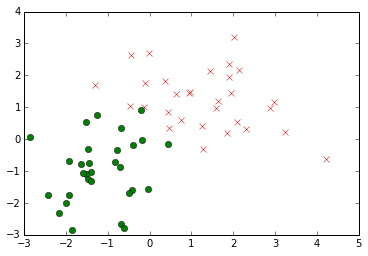

In [2]:
np.random.seed(seed=1000001)
x_plus = np.random.normal(loc=1.3, size=(30, 2))
x_minus = np.random.normal(loc=-1.3, size=(30, 2))

# plot data
plt.plot(x_plus[:, 0], x_plus[:, 1], 'rx')
plt.plot(x_minus[:, 0], x_minus[:, 1], 'go')


### Mathematical Drawing of Decision Boundary

**Refresher**: draw a hyper plane at decision boundary.
 - *Decision boundary*: plane where a point moves from being classified as -1 to +1. 
 - We have

   $$\text{sign}(\mathbf{x}^\top \mathbf{w}) = \text{sign}(w_0 + w_1x_{i,1} + w_2 x_{i, 2})$$

   $x_{i, 1}$ is first feature $x_{i, 2}$ is second feature assume $x_{0,i}=1$. 
 
 - Set $w_0 = b$ we have
 
   $$\text{sign}\left(w_1 x_{i, 1} + w_2 x_{i, 2} + b\right)$$

### Equation of Plane

$$\text{sign}\left(w_1 x_{i, 1} + w_2 x_{i, 2} + b\right)$$

- Equation of plane is 
  
  $$w_1 x_{i, 1} + w_2 x_{i, 2} + b = 0$$ 
  
  or
  
    $$w_1 x_{i, 1} + w_2 x_{i, 2} = -b$$ 
    
- Next we will initialise the model and draw a decision boundary.


### Perceptron Algorithm: Initialisation Maths

- For a randomly chosen data point, $i$, set

  $$\mathbf{w} = y_i \mathbf{x}_i$$

- If predicted label of the $i$th point is 

  $$\text{sign}(\mathbf{w}^\top\mathbf{x}_i)$$

- Setting $\mathbf{w}$ to $y_i\mathbf{x}_i$ implies

  $$\text{sign}(\mathbf{w}^\top\mathbf{x}_i) = \text{sign}(y_i\mathbf{x}_i^\top \mathbf{x}_i) = y_i$$

### Perceptron Algorithm: Initialisation Code

In [ ]:
# %load -s init_perceptron mlai.py
def init_perceptron(x_plus, x_minus, seed=1000001):
    np.random.seed(seed=seed)
    # flip a coin (i.e. generate a random number and check if it is greater than 0.5)
    choose_plus = np.random.rand(1)>0.5
    if choose_plus:
        # generate a random point from the positives
        index = np.random.randint(0, x_plus.shape[1])
        x_select = x_plus[index, :]
        w = x_plus[index, :] # set the normal vector to that point.
        b = 1
    else:
        # generate a random point from the negatives
        index = np.random.randint(0, x_minus.shape[1])
        x_select = x_minus[index, :]
        w = -x_minus[index, :] # set the normal vector to minus that point.
        b = -1
    return w, b, x_select


### Computing Decision Boundary

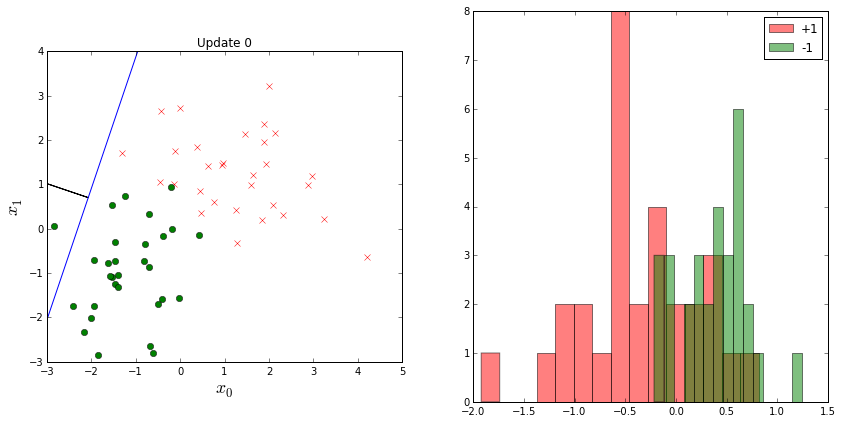

In [4]:
f, ax = plt.subplots(1, 2, figsize=(14,7))
w, b = init_perceptron(x_plus, x_minus)
handle = plot.init_perceptron(f, ax, x_plus, x_minus, w, b)

   
### Drawing Decision Boundary

The decision boundary is where the output of the function changes from -1 to +1 (or vice versa) so it's the point at which the argument of the $\text{sign}$ function is zero. So in other words, the decision boundary is given by the *line* defined by $x_1 w_1 + x_2 w_2 = -b$ (where we have dropped the index $i$ for convenience). In this two dimensional space the decision boundary is defined by a line. In a three dimensional space it would be defined by a *plane*  and in higher dimensional spaces it is defined by something called a *hyperplane* (http://en.wikipedia.org/wiki/Hyperplane). This equation is therefore often known as the *separating hyperplane* because it defines the hyperplane that separates the data. To draw it in 2-D we can choose some values to plot from $x_1$ and then find the corresponding values for $x_2$ to plot using the rearrangement of the hyperplane formula as follows

$$x_2 = -\frac{(b+x_1w_1)}{w_2}$$

Of course, we can also choose to specify the values for $x_2$ and compute the values for $x_1$ given the values for $x_2$,

$$x_1 = -\frac{b + x_2w_2}{w_1}$$

### Switching Formulae

It turns out that sometimes we need to use the first formula, and sometimes we need to use the second. Which formula we use depends on how the separating hyperplane leaves the plot. 

We want to draw the separating hyperplane in the bounds of the plot which is showing our data. To think about which equation to use, let's consider two separate situations (actually there are a few more). 

1. If the separating hyperplane leaves the top and bottom of the plot then we want to plot a line with values in the $y$ direction (given by $x_2$) given by the upper and lower limits of our plot. The values in the $x$ direction can then be computed from the formula for the plane. 

2. Conversely if the line leaves the sides of the plot then we want to plot a line with values in the $x$ direction given by the limits of the plot. Then the values in the $y$ direction can be computed from the formula. Whether the line leaves the top/bottom or the sides of the plot is dependent on the relative values of $w_1$ and $w_2$. 

This motivates a simple `if` statement to check which situation we're in.

### Code for Perceptron

In [ ]:
# %load -s update_perceptron mlai.py
def update_perceptron(w, b, x_plus, x_minus, learn_rate):
    "Update the perceptron."
    # select a point at random from the data
    choose_plus = np.random.uniform(size=1)>0.5
    updated=False
    if choose_plus:
        # choose a point from the positive data
        index = np.random.randint(x_plus.shape[0])
        x_select = x_plus[index, :]
        if np.dot(w, x_select)+b <= 0.:
            # point is currently incorrectly classified
            w += learn_rate*x_select
            b += learn_rate
            updated=True
    else:
        # choose a point from the negative data
        index = np.random.randint(x_minus.shape[0])
        x_select = x_minus[index, :]
        if np.dot(w, x_select)+b > 0.:
            # point is currently incorrectly classified
            w -= learn_rate*x_select
            b -= learn_rate
            updated=True
    return w, b, x_select, updated


Data passes: 494


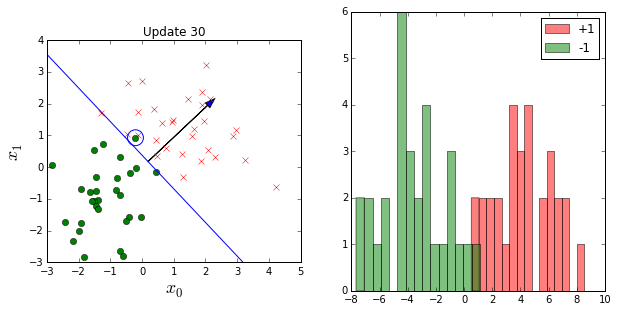

In [6]:
plots = plot.perceptron(x_plus, x_minus)

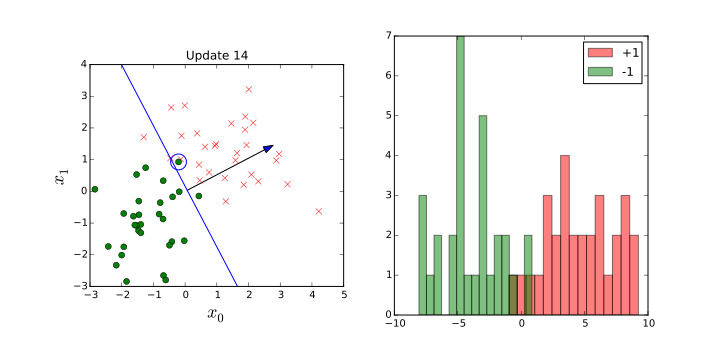

In [7]:
pods.notebook.display_plots('perceptron{samp:0>3}.svg', directory='./diagrams', samp=(0, plots))

### Perceptron Reflection

 - The perceptron is an algorithm. 
 - What is it doing? When will it fail?
 - We can explain the update equations and proove it converges.
 - Normally it is far easier to first define an *objective function*.
 - Also known as a:
     - loss function
     - error function
     - cost function

### Objective Functions and Regression

- Classification: map feature to class label.
- Regression: map feature to real value our *prediction function* is

    $$f(x_i) = mx_i + c$$

- Need an *algorithm* to fit it. 

- Least squares: minimize an error.

$$E(m, c) = \sum_{i=1}^n (y_i - f(x_i))^2$$



### Regression

- Create an artifical data set.



In [8]:
x = np.random.normal(size=4)

We now need to decide on a *true* value for $m$ and a *true* value for $c$ to use for generating the data. 

In [9]:
m_true = 1.4
c_true = -3.1

We can use these values to create our artificial data. The formula 
$$y_i = mx_i + c$$ is translated to code as follows:

In [10]:
y = m_true*x+c_true

### Plot of Data
We can now plot the artifical data we've created.

(-3, 3)

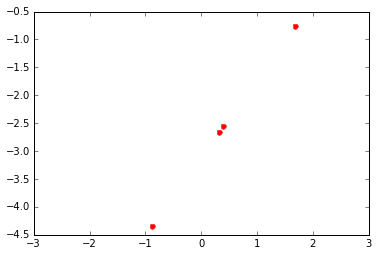

In [11]:
plt.plot(x, y, 'r.', markersize=10) # plot data as red dots
plt.xlim([-3, 3])

These points lie exactly on a straight line, that's not very realistic, let's corrupt them with a bit of Gaussian 'noise'.

### Noise Corrupted Plot

(-3, 3)

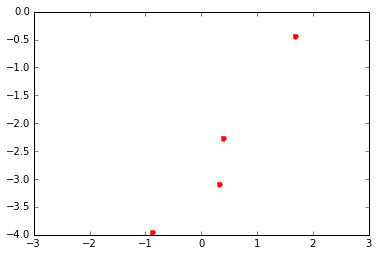

In [12]:
noise = np.random.normal(scale=0.5, size=4) # standard deviation of the noise is 0.5
y = m_true*x + c_true + noise
plt.plot(x, y, 'r.', markersize=10)
plt.xlim([-3, 3])

### Contour Plot of Error Function

- Visualise the error function surface, create vectors of values.

In [13]:
# create an array of linearly separated values around m_true
m_vals = np.linspace(m_true-3, m_true+3, 100) 
# create an array of linearly separated values ae
c_vals = np.linspace(c_true-3, c_true+3, 100) 

- create a grid of values to evaluate the error function in 2D.

In [14]:
m_grid, c_grid = np.meshgrid(m_vals, c_vals) 

- compute the error function at each  combination of $c$ and $m$.


In [15]:
E_grid = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        E_grid[i, j] = ((y - m_grid[i, j]*x - c_grid[i, j])**2).sum()

# Contour Plot of Error

 - We can now make a contour plot.

In [16]:
# %load -s regression_contour teaching_plots.py
def regression_contour(f, ax, m_vals, c_vals, E_grid):
    "Regression contour plot."
    hcont = ax.contour(m_vals, c_vals, E_grid, levels=[0, 0.5, 1, 2, 4, 8, 16, 32, 64]) # this makes the contour plot 
    plt.clabel(hcont, inline=1, fontsize=15) # this labels the contours.

    ax.set_xlabel('$m$', fontsize=25)
    ax.set_ylabel('$c$', fontsize=25)


/Users/neil/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/neil/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


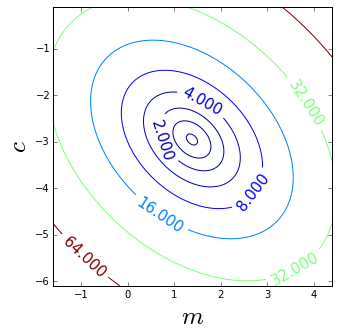

In [17]:
f, ax = plt.subplots(figsize=(5,5))
regression_contour(f, ax, m_vals, c_vals, E_grid)
plt.savefig('./diagrams/regression_contour.svg')

<img src='./diagrams/regression_contour.svg' width="50%">

### Steepest Descent

- Minimize the sum of squares error function. 
- One way of doing that is gradient descent. 
- Initialize with a guess for $m$ and $c$ 
- update that guess by subtracting a portion of the gradient from the guess. 
- Like walking down a hill in the steepest direction of the hill to get to the bottom.

### Algorithm

- We start with a guess for $m$ and $c$.

In [18]:
m_star = 0.0
c_star = -5.0

### Offset Gradient

- Now we need to compute the gradient of the error function, firstly with respect to $c$,

  $$\frac{\text{d}E(m, c)}{\text{d} c} = -2\sum_{i=1}^n (y_i - mx_i - c)$$

- This is computed in python as follows

In [19]:
c_grad = -2*(y-m_star*x - c_star).sum()
print("Gradient with respect to c is ", c_grad)

Gradient with respect to c is  -20.5383119891


### Deriving the Gradient

To see how the gradient was derived, first note that the $c$ appears in every term in the sum. So we are just differentiating $(y_i - mx_i - c)^2$ for each term in the sum. The gradient of this term with respect to $c$ is simply the gradient of the outer quadratic, multiplied by the gradient with respect to $c$ of the part inside the quadratic. The gradient of a quadratic is two times the argument of the quadratic, and the gradient of the inside linear term is just minus one. This is true for all terms in the sum, so we are left with the sum in the gradient. 

### Slope Gradient

The gradient with respect tom $m$ is similar, but now the gradient of the quadratic's argument is $-x_i$ so the gradient with respect to $m$ is

$$\frac{\text{d}E(m, c)}{\text{d} m} = -2\sum_{i=1}^n x_i(y_i - mx_i - c)$$

which can be implemented in python (numpy) as

In [20]:
m_grad = -2*(x*(y-m_star*x - c_star)).sum()
print("Gradient with respect to m is ", m_grad)

Gradient with respect to m is  -16.7826656448


### Update Equations


- Now we have gradients with respect to $m$ and $c$.
- Can update our inital guesses for $m$ and $c$ using the gradient. 
- We don't want to just subtract the gradient from $m$ and $c$, 
- We need to take a *small* step in the gradient direction. 
- Otherwise we might overshoot the minimum. 
- We want to follow the gradient to get to the minimum, the gradient changes all the time. 


### Move in Direction of Gradient

/Users/neil/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/neil/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


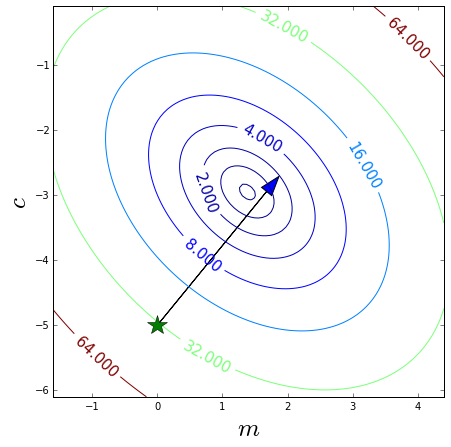

In [21]:
f, ax = plt.subplots(figsize=(7,7))
plot.regression_contour(f, ax, m_vals, c_vals, E_grid)
ax.plot(m_star, c_star, 'g*', markersize=20)
ax.arrow(m_star, c_star, -m_grad*0.1, -c_grad*0.1, head_width=0.2)
plt.savefig('./diagrams/regression_contour_step1.svg')

<img src='./diagrams/regression_contour_step1.svg' width="50%">

## Update Equations 

- The step size has already been introduced, it's again known as the learning rate and is denoted by $\eta$. 

  $$c_\text{new} \leftarrow c_{\text{old}} - \eta \frac{\text{d}E(m, c)}{\text{d}c}$$ 

- gives us an update for our estimate of $c$ (which in the code we've been calling `c_star` to represent a common way of writing a parameter estimate, $c^*$) and 

  $$m_\text{new} \leftarrow m_{\text{old}} - \eta \frac{\text{d}E(m, c)}{\text{d}m}$$
  
- Giving us an update for $m$.

## Update Code

- These updates can be coded as

In [22]:
print("Original m was", m_star, "and original c was", c_star)
learn_rate = 0.01
c_star = c_star - learn_rate*c_grad
m_star = m_star - learn_rate*m_grad
print("New m is", m_star, "and new c is", c_star)


Original m was 0.0 and original c was -5.0
New m is 0.167826656448 and new c is -4.79461688011


# Iterating Updates

- Fit model by descending gradient. 

### Gradient Descent Algorithm

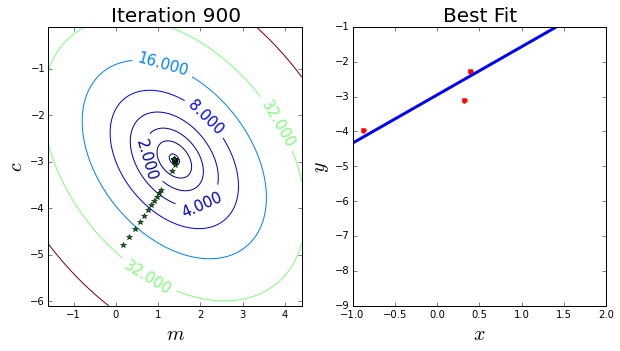

In [23]:
num_plots = plot.regression_contour_fit(x, y)

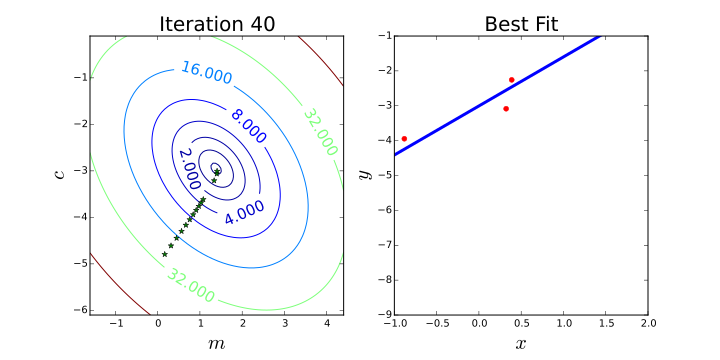

In [24]:
pods.notebook.display_plots('regression_contour_fit{num:0>3}.svg', directory='./diagrams', num=(0, num_plots))

### Stochastic Gradient Descent

- If $n$ is small, gradient descent is fine.
- But sometimes (e.g. on the internet $n$ could be a billion.
- Stochastic gradient descent is more similar to perceptron.
- Look at gradient of one data point at a time rather than summing across *all* data points) 
- This gives a stochastic estimate of gradient.

 

### Stochastic Gradient Descent

- The real gradient with respect to $m$ is given by 

  $$\frac{\text{d}E(m, c)}{\text{d} m} = -2\sum_{i=1}^n x_i(y_i - mx_i - c)$$

  but it has $n$ terms in the sum. Substituting in the gradient we can see that the full update is of the form

  $$m_\text{new} \leftarrow m_\text{old} + 2\eta \left[x_1 (y_1 - m_\text{old}x_1 - c_\text{old}) + (x_2 (y_2 -   m_\text{old}x_2 - c_\text{old}) + \dots + (x_n (y_n - m_\text{old}x_n - c_\text{old})\right]$$

  This could be split up into lots of individual updates

$$m_1 \leftarrow m_\text{old} + 2\eta \left[x_1 (y_1 - m_\text{old}x_1 - c_\text{old})\right]$$
$$m_2 \leftarrow m_1 + 2\eta \left[x_2 (y_2 - m_\text{old}x_2 - c_\text{old})\right]$$
$$m_3 \leftarrow m_2 + 2\eta \left[\dots\right]$$
$$m_n \leftarrow m_{n-1} + 2\eta \left[x_n (y_n - m_\text{old}x_n - c_\text{old})\right]$$

which would lead to the same final update.

### Updating $c$ and $m$

- In the sum we don't  $m$ and $c$ we use for computing the gradient term at each update. 
- In stochastic gradient descent we *do* change them.
- This means it's not quite the same as steepest desceint.
- But we  can present each data point in a random order, like we did for the perceptron.
- This makes the algorithm suitable for large scale web use (recently this domain is know as 'Big Data') and algorithms like this are widely used by Google, Microsoft, Amazon, Twitter and Facebook.


### Stochastic Gradient Descent

- Or more accurate, since the data is normally presented in a random order we just can write

  $$m_\text{new} = m_\text{old} + 2\eta\left[x_i (y_i - m_\text{old}x_i - c_\text{old})\right]$$

In [25]:
# choose a random point for the update
i = np.random.randint(x.shape[0]-1)
# update m
m_star = m_star + 2*learn_rate*(x[i]*(y[i]-m_star*x[i] - c_star))
# update c
c_star = c_star + 2*learn_rate*(y[i]-m_star*x[i] - c_star)

### SGD for Linear Regression

Putting it all together in an algorithm, we can do stochastic gradient descent for our regression data.

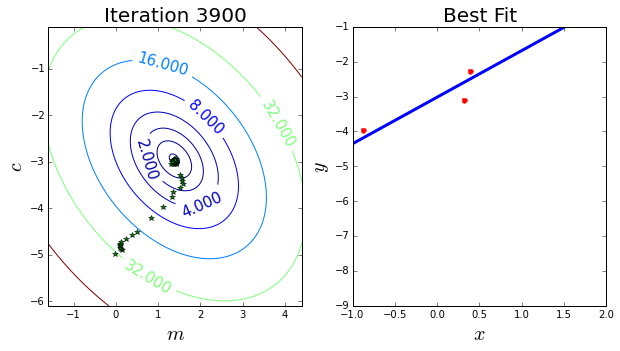

In [26]:
num_plots = plot.regression_contour_sgd(x, y)
        


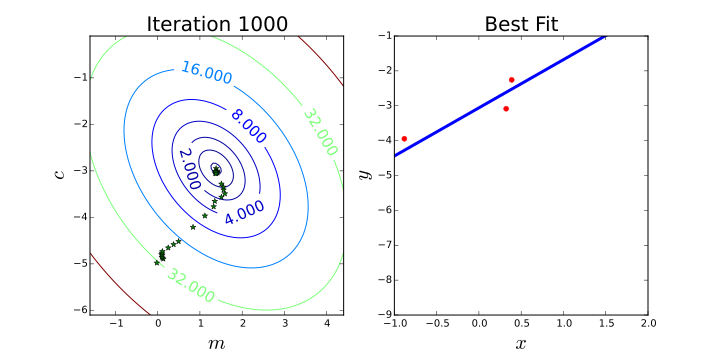

In [27]:
pods.notebook.display_plots('regression_sgd_contour_fit{num:0>3}.svg', directory='./diagrams', num=(0, num_plots))

### Reflection on Linear Regression and Supervised Learning

Think about:

1. What effect does the learning rate have in the optimization? What's the effect of making it too small, what's the effect of making it too big? Do you get the same result for both stochastic and steepest gradient descent?

2. The stochastic gradient descent doesn't help very much for such a small data set. It's real advantage comes when there are many, you'll see this in the lab.


### Lab Class

- You will take the ideas you have learnt.
- You will apply them in the domain of *matrix factorisation*.
- Matrix factorization presents a different error function.

### Reading
- Section 1.1.3 of @Rogers:book11 for loss functions.